Philippe Joly 2025-06-07

# CHAIM Ionosphere Plasma Frequency Overview

This notebook is simply to llok over the A/E-CHAIM data and the critical plasma frequency across the observational times

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import sys
from scipy.interpolate import make_smoothing_spline
from os import path
sys.path.append(path.expanduser('~'))

## Load CHAIM Data

In [23]:
fns = [
    "/project/rrg-sievers/philj0ly/CHAIM/CSV/ACHAIM_nmf2.csv",
    "/project/rrg-sievers/philj0ly/CHAIM/CSV/ECHAIM_nmf2.csv"
]

achaim = pd.read_csv(fns[0])
echaim = pd.read_csv(fns[1])
dfs = [achaim, echaim]

obs_period = [1721342139, 1721449881]
for i, t in enumerate(obs_period):
    obs_period[i] = pd.to_datetime(t, unit='s')
   
for i, df in enumerate(dfs):
    df["datetime"] = pd.to_datetime(df["datetime"], format="%y%m%d_%H%M%S")
    dfs[i] = df[(df['datetime'] >= obs_period[0]) & (df['datetime'] <= obs_period[1])].copy()

print(f"Loaded {len(dfs[0])} Data points from {obs_period[0]} to {obs_period[1]}")

Loaded 197 Data points from 2024-07-18 22:35:39 to 2024-07-20 04:31:21


In [24]:
eps = 8.8541878188 * 1e-12 # vacuum electric permittivity  [ F / m]
m_e = 9.1093837139 * 1e-31 # electron mass [ kg ]
e = 1.602176634  * 1e-19 # electron charge [ C ]

def get_plasma_freq(nmf2):
    w_p = np.sqrt( nmf2 * e**2 / (m_e * eps) )
    return w_p / (2*np.pi)

for df in dfs:
    df["plasma_freq"] = get_plasma_freq(df["nmf2"])

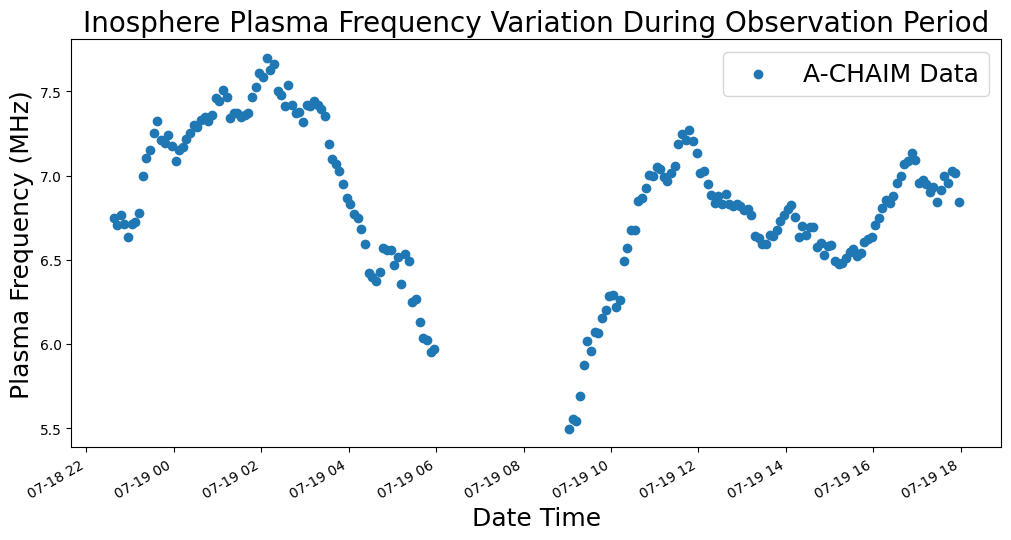

In [29]:
model = ['A-CHAIM Data','E-CHAIM']

fig, ax = plt.subplots(figsize=(12,6))

for i, df in enumerate(dfs):
    ax.scatter(df["datetime"], df["plasma_freq"]*1e-6, label=model[i])
    break

# date_format = mdates.DateFormatter("%d_%H%M")
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(rotation=45)
# or
plt.gcf().autofmt_xdate()

plt.title("Inosphere Plasma Frequency Variation During Observation Period", fontsize=20)
plt.xlabel("Date Time", fontsize=18)
plt.ylabel("Plasma Frequency (MHz)", fontsize=18)
plt.legend(fontsize=18)
plt.show()    

Looking at the full observational period we see that the max value is ~ 8.2 MHz and the lowest ~ 4.25 MHz. Note that there are significant gaps in the data.

## Load 1 kHz Data

In [5]:
with np.load("/project/s/sievers/mohanagr/xcorr_axion/xcorr_all_ant_4bit_1721361571_14336_64_15326_0_120.npz") as f:
    data = f['data']
    mask = f['mask']
    missing_fraction = f["missing_fraction"]
    chans = f['chans']

N = 14336
df_record = 125e6/2048
df = df_record/64

spectra = np.ma.MaskedArray(data=data, mask=mask)
freqs = chans*df 
t0 = 1721361571
times = N/df_record*np.arange(15326)+t0

## Scout Spectrum

In [12]:
start_t = 1721361671 # (s)
T = 240*60 #(s)
obs_1k = [start_t, start_t+T]

for i, t in enumerate(obs_1k):
    obs_1k[i] = pd.to_datetime(t, unit='s')
    
plasma = dfs[0][(dfs[0]['datetime'] >= obs_1k[0]) & (dfs[0]['datetime'] <= obs_1k[1])].copy()

if len(plasma) == 0:
    raise ValueError(f"No plasma frequency between {obs_1k[0]} and {obs_1k[1]}")
else:
    print(f"Loaded {len(plasma)} Data points from {obs_1k[0]} to {obs_1k[1]}")

Loaded 24 Data points from 2024-07-19 04:01:11 to 2024-07-19 08:01:11


In [13]:
prange = [plasma["plasma_freq"].min(), plasma["plasma_freq"].max()]

print("Maximum absolute plasma frequency variation:", prange[1]-prange[0])

bins = []
for i in range(70):
    if (65+i)*df_record < prange[0]:
        continue
    if (64+i)*df_record > prange[1]:
        break
    else:
        bins.append(i)

print(len(bins), "frequency bins fall within that range:")
print(bins, "(+64)")

Maximum absolute plasma frequency variation: 882152.9699185044
15 frequency bins fall within that range:
[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47] (+64)


/tmp/ipykernel_480/3581095257.py:19: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(


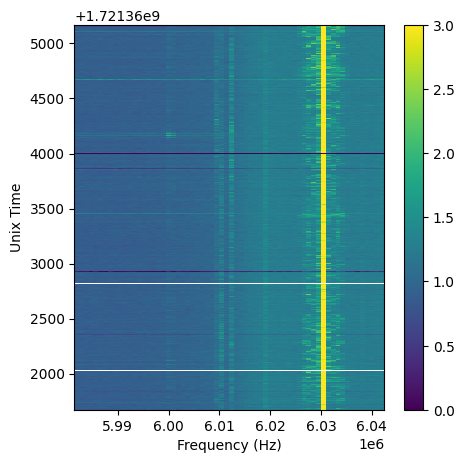

In [14]:
# Inspect channel of interest
chnls = [bins[1]*64, (bins[1]+1)*64]

# Convert time to indxs
def get_closest(arr, n):
    diff = np.abs(arr-n)
    return np.argmin(diff)


plt.figure(figsize=(5,5))
extent = [
    freqs[chnls[0]],
    freqs[chnls[1]],
    times[get_closest(times, start_t)], 
    times[get_closest(times, start_t+T)]
]

plt.imshow(
    np.log10(np.abs(
        spectra[0, 0, chnls[0]:chnls[1], get_closest(times, start_t):get_closest(times, start_t+T)].T
    )), 
    aspect='auto', vmin=0, vmax=3, interpolation='none', origin="lower", extent=extent)

plt.ylabel("Unix Time")
plt.xlabel("Frequency (Hz)")
plt.colorbar()
# plt.show()

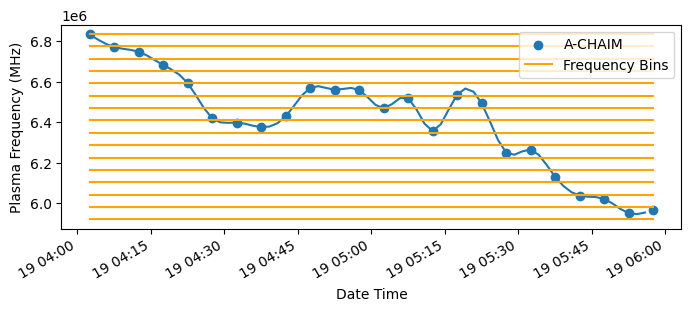

In [36]:
fig, ax = plt.subplots(figsize=(8,3))

ax.scatter(plasma["datetime"], plasma["plasma_freq"], label="A-CHAIM")

x = np.linspace(plasma["datetime"].values[0].astype(np.int64) // 10**9, plasma["datetime"].values[-1].astype(np.int64) // 10**9, 1000, endpoint=True)
spl = make_smoothing_spline(plasma["datetime"].values.astype(np.int64) // 10**9, plasma["plasma_freq"].values, lam=0)

ax.plot(pd.to_datetime(x, unit='s'), spl(x))

unos = np.ones(plasma["datetime"].shape[0])
for i in bins:
    ax.plot(plasma["datetime"], unos*freqs[i*64], color="orange")
ax.plot(plasma["datetime"], unos*freqs[(bins[-1]+1)*64], color="orange", label="Frequency Bins")

plt.gcf().autofmt_xdate()

plt.xlabel("Date Time")
plt.ylabel("Plasma Frequency (MHz)")
plt.legend()
plt.show()   